# HW03

Будем практиковаться на датасете недвижимости (sklearn.datasets.fetch_california_housing)

Ваша задача:

Создать Dataset для загрузки данных

Обернуть его в Dataloader

Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)

Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [51]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
import torchmetrics
import torch.nn.functional as F

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [53]:
train_dataset = sklearn.datasets.fetch_california_housing()
print(train_dataset.DESCR)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [54]:
data = train_dataset.data
target = train_dataset.target

In [55]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=13)

In [56]:
# сделаем стандарт-скейлер так как это задача регрессии и мин-макс скейлер будет хуже работать

scaler = MinMaxScaler()
# scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [57]:
class MyOwnCH(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
    
train_dataset = MyOwnCH(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_dataset = MyOwnCH(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [58]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False, drop_last=True, num_workers=0)

In [59]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation == "relu":
            return F.relu(x)
        if self.activation == "sigmoid":
            return F.sigmoid(x)
        raise RuntimeError
        
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 2 * hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2 * hidden_dim)
        self.fc2 = Perceptron(2 * hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.25)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn3(x)
        x = self.fc3(x)
        return x

In [60]:
def model_comparing(model, optimizer, epochs = 30):    
    
    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()

    r2_train_list = []
    r2_test_list = []
    
    for epoch in range(epochs):
        
        model.train()
        
        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1]
            optimizer.zero_grad()
            outputs = model(inputs)
            batch_r2 = train_r2(outputs.squeeze(), target)
            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs.squeeze(), target)
            loss.backward()
            optimizer.step()
        
        model.eval()
        
        for i, data in enumerate(test_loader):
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            test_r2(outputs.squeeze(), target)

        # total r2 over all training batches
        total_train_r2 = train_r2.compute()
        # total r2 over all training batches
        total_test_r2 = test_r2.compute()
        
        r2_train_list.append(total_train_r2)
        r2_test_list.append(total_test_r2)
        print(f'Epoch {epoch+1}: r2_train = {total_train_r2}, r2_test = {total_test_r2}')

        #reset for next epoch
        train_r2.reset()
        test_r2.reset()
    
    return r2_train_list, r2_test_list

In [61]:
def metrics_view(r2_train_list, r2_test_list, optim, epochs = 30):
    
    epoch = np.arange(1,epochs + 1,1)
    y_train = r2_train_list
    y_test = r2_test_list
    plt.plot(epoch, y_train, label='R2_train')
    plt.plot(epoch, y_test, label='R2_test')
    plt.title(f"{optim}")   
    plt.ylabel('R2_score')   
    plt.xlabel('epochs')   
    plt.legend()
    plt.show()

In [62]:
epochs = 50

### SGD

In [63]:
model = FeedForward(8, 400)
print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.0)
r2_train_SGD, r2_test_SGD = model_comparing(model, optimizer, epochs)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

FeedForward(
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Perceptron(
    (fc): Linear(in_features=8, out_features=800, bias=True)
  )
  (dp1): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Perceptron(
    (fc): Linear(in_features=800, out_features=400, bias=True)
  )
  (dp2): Dropout(p=0.25, inplace=False)
  (bn3): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Perceptron(
    (fc): Linear(in_features=400, out_features=1, bias=True)
  )
)
Epoch 1: r2_train = -0.9493361711502075, r2_test = -0.2505873441696167
Epoch 2: r2_train = -0.34838759899139404, r2_test = -0.015439748764038086
Epoch 3: r2_train = -0.175567626953125, r2_test = 0.061093032360076904
Epoch 4: r2_train = -0.06646358966827393, r2_test = 0.21466940641403198
Epoch 5: r2_train = 0.008794069290161133, r2_test = 0.18406414985656738
Epoch 6: r2_train

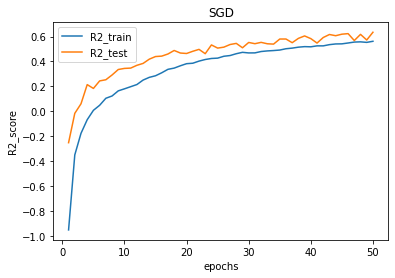

In [64]:
metrics_view(r2_train_SGD, r2_test_SGD, 'SGD', epochs)

### RMSprop

In [65]:
model = FeedForward(8, 400)
# print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)
r2_train_RMSprop, r2_test_RMSprop = model_comparing(model, optimizer, epochs)

Epoch 1: r2_train = 0.2683691382408142, r2_test = 0.4922531843185425
Epoch 2: r2_train = 0.5101662874221802, r2_test = 0.6251602172851562
Epoch 3: r2_train = 0.5745571255683899, r2_test = 0.6655621528625488
Epoch 4: r2_train = 0.6064989566802979, r2_test = 0.637948215007782
Epoch 5: r2_train = 0.6339069604873657, r2_test = 0.6834486722946167
Epoch 6: r2_train = 0.6335992813110352, r2_test = 0.7068344354629517
Epoch 7: r2_train = 0.6603686213493347, r2_test = 0.7108429670333862
Epoch 8: r2_train = 0.6618843674659729, r2_test = 0.6825525164604187
Epoch 9: r2_train = 0.6680257320404053, r2_test = 0.6836836338043213
Epoch 10: r2_train = 0.6689243316650391, r2_test = 0.7345837950706482
Epoch 11: r2_train = 0.6785697340965271, r2_test = 0.6890488862991333
Epoch 12: r2_train = 0.6857689023017883, r2_test = 0.7477763891220093
Epoch 13: r2_train = 0.6872525215148926, r2_test = 0.735877275466919
Epoch 14: r2_train = 0.6938834190368652, r2_test = 0.7402084469795227
Epoch 15: r2_train = 0.69680225

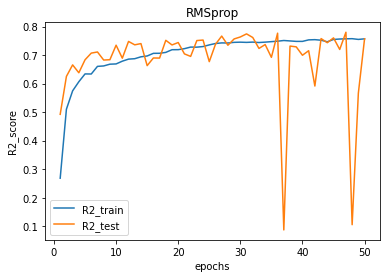

In [66]:
metrics_view(r2_train_RMSprop, r2_test_RMSprop, 'RMSprop', epochs)

### ADAM

In [67]:
model = FeedForward(8, 400)
# print(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
r2_train_Adam, r2_test_Adam = model_comparing(model, optimizer, epochs)

Epoch 1: r2_train = 0.0535351037979126, r2_test = 0.4987008571624756
Epoch 2: r2_train = 0.4482194781303406, r2_test = 0.5838340520858765
Epoch 3: r2_train = 0.5386960506439209, r2_test = 0.6117403507232666
Epoch 4: r2_train = 0.5995491743087769, r2_test = 0.658470630645752
Epoch 5: r2_train = 0.6264145374298096, r2_test = 0.6958808898925781
Epoch 6: r2_train = 0.6453955769538879, r2_test = 0.6513484716415405
Epoch 7: r2_train = 0.6569029092788696, r2_test = 0.7280986309051514
Epoch 8: r2_train = 0.660873293876648, r2_test = 0.6690998077392578
Epoch 9: r2_train = 0.6696071624755859, r2_test = 0.7233245372772217
Epoch 10: r2_train = 0.6829065084457397, r2_test = 0.7468746900558472
Epoch 11: r2_train = 0.6868758201599121, r2_test = 0.7401450872421265
Epoch 12: r2_train = 0.6876324415206909, r2_test = 0.7444343566894531
Epoch 13: r2_train = 0.6913514137268066, r2_test = 0.7412967085838318
Epoch 14: r2_train = 0.7034308314323425, r2_test = 0.7545970678329468
Epoch 15: r2_train = 0.70436561

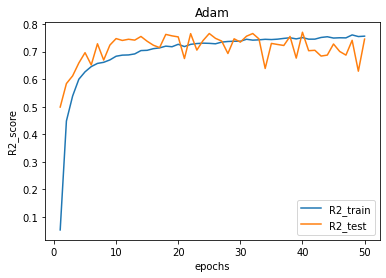

In [68]:
metrics_view(r2_train_Adam, r2_test_Adam, 'Adam', epochs)

### Сравнение метрик

In [69]:
metrics_result = pd.DataFrame([{'r2_train': r2_train_SGD[-1].item(), 'r2_test': r2_test_SGD[-1].item()},
                               {'r2_train': r2_train_RMSprop[-1].item(), 'r2_test': r2_test_RMSprop[-1].item()},
                               {'r2_train': r2_train_Adam[-1].item(), 'r2_test': r2_test_Adam[-1].item()},
                              ],
                              index = ['SGD', 'RMSprop', 'Adam'], 
                              columns = ['r2_train', 'r2_test'])

metrics_result.sort_values(by='r2_test', ascending=False)

,r2_train,r2_test
RMSprop,0.756887,0.757086
Adam,0.755670,0.745018
SGD,0.561846,0.634274


Алгоримт SGD долго сходится - но достаточно стабильно. Ему требуется больше эпох, чтобы прийти к значениям метрик, которые достигаются другими алгоритмами значительно быстрее.

Алгоритмы Adam и RMSprop сходятся примерно одинаково. И быстрее чем SGD.